In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA GeForce RTX 3090, 24576 MiB, 24246 MiB


https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

## Settings and run

In [2]:
#@markdown Name/Path of the initial model.
MODEL_NAME = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown Path for images of the concept for training.
INSTANCE_DIR = "/home/huggingface/training_images/sofi" #@param {type:"string"}
!mkdir -p $INSTANCE_DIR

#@markdown A general name for class like dog for dog images.
CLASS_NAME = "little girl, 4 k ultra high resolution" #@param {type:"string"}
CLASS_DIR = f"/home/huggingface/training_images/girl4k"

# #@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
# save_to_gdrive = True #@param {type:"boolean"}
# if save_to_gdrive:
#     from google.colab import drive
#     drive.mount('/content/drive')

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "/home/huggingface/output_weights/sofi3" #@param {type:"string"}
IMG_OUTPUT_DIR = "/home/huggingface/output"

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

import os
import glob

def save_images(images):
    gl = glob.glob(IMG_OUTPUT_DIR+os.sep+"*.jpg", recursive=False)
    max_idx = 0
    for name in gl:
        try:
            v = int(os.path.basename(name)[:-4])
            if v>max_idx: max_idx = v
        except:
            pass
    
    bidx = max_idx+1
    
    for idx, img in enumerate(images):
        img.save(IMG_OUTPUT_DIR + os.sep + f"{bidx+idx}.jpg")



#@markdown sks is a rare identifier, feel free to replace it.

[*] Weights will be saved at /home/huggingface/output_weights/sofi3


# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

In [4]:
# !accelerate launch train_dreambooth.py \
!python train_dreambooth.py \
  --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4" \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir="{OUTPUT_DIR}" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt='"photo of sofi {CLASS_NAME}"' \
  --class_prompt='"photo of a {CLASS_NAME}"' \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=20 \
  --sample_batch_size=4 \
  --max_train_steps=900


Generating class images: 100%|████████████████████| 5/5 [01:19<00:00, 15.96s/it]
Creating output dir /home/huggingface/output_weights/sofi3

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
/usr/local/lib/python3.8/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib64'), PosixPath('/usr/local/cuda/extras/CUPTI/lib64'), PosixPath('/usr/local/nvidia/lib')}
  warn(
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA ve

## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [ ]:
#@markdown Download script
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py

In [ ]:
#@markdown Run conversion.
ckpt_path = OUTPUT_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB), might loose some quality.
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

## Inference

In [3]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from IPython.display import display

model_path = OUTPUT_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")
g_cuda = None

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 1 #@param {type:"number"}
g_cuda.manual_seed(seed)

100%|██████████| 51/51 [00:15<00:00,  3.36it/s]


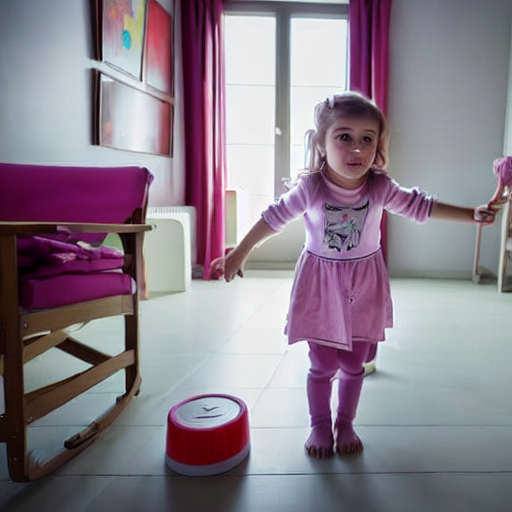

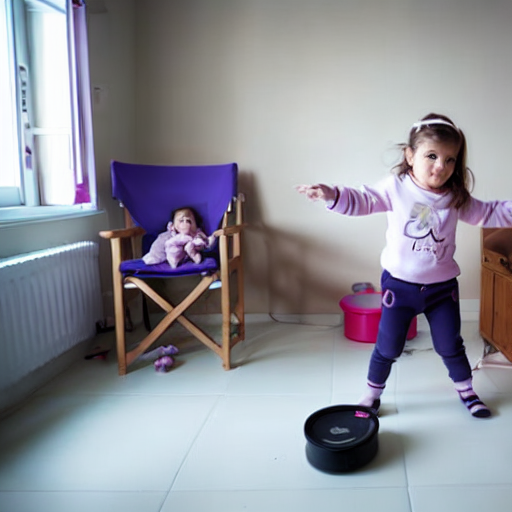

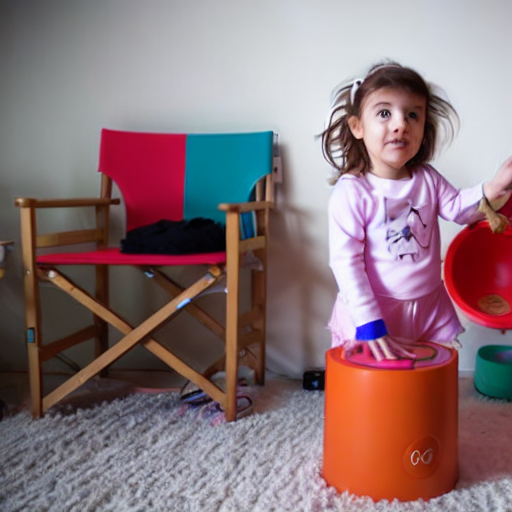

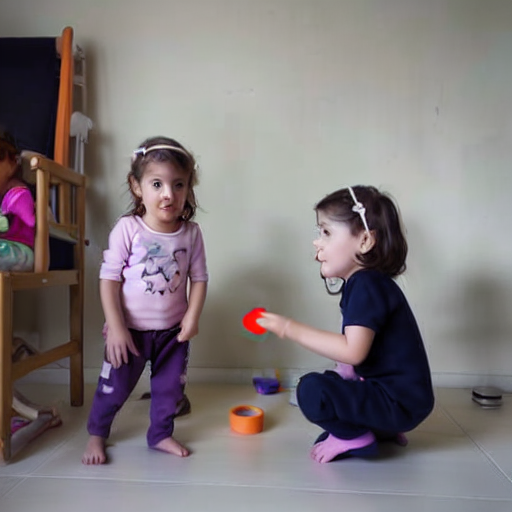

In [14]:
#@title Run for generating images.

# prompt = "photo of sofi dressed as little mermaid, 4 k ultra high resolution, in the style of wes andesron, complimentary color palette, with a feeling of fun" #@param {type:"string"}
# prompt = "photo of sofi staring as the little mermaid in the movie, brown eyes, black hair, close up photo" #@param {type:"string"}
# prompt = "photo of sofi holding the ring of power, brown eyes, black hair, close up photo,  middle earth, 4 k ultra high resolution, in the style of wes andesron, complimentary color palette, with a feeling of fun" #@param {type:"string"}
prompt = "Sofi in her house playing with her baby sister, 4 k ultra high resolution" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe([prompt] * num_samples, height=height, width=width, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=g_cuda).images

for img in images:
    display(img)

save_images(images)

In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
            [prompt]*int(num_samples), height=int(height), width=int(width),
            num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
            generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of sks guy, digital painting")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

In [ ]:
#@title (Optional) Delete diffuser weights and only keep the ckpt to free up drive space (4GB).

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
for f in glob(OUTPUT_DIR+"/*"):
    if not f.endswith(".ckpt"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)